In [1]:
import os, random
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
physical_devices = tf.config.list_physical_devices('GPU')
tf.keras.backend.clear_session
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2025-10-03 10:53:23.679385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
num_skipped = 0
for folder_name in ("Photo", "Other"):
    folder_path = os.path.join("/mnt/e/Shared", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

KeyboardInterrupt: 

In [16]:
from PIL import Image
import shutil
from pathlib import Path
DATA_ROOT = Path("/mnt/e/Shared")
CLASS_DIRS = ["Photo", "Other"]
QUARANTINE = DATA_ROOT / "_corrupted"
QUARANTINE.mkdir(exist_ok=True)
ALLOWED_EXT = {".jpg", ".jpeg", ".png"}

def is_valid_image(path: Path) -> bool:
    try:
        with Image.open(path) as im:
            im.verify()          # vérifie l'en-tête
        with Image.open(path) as im:
            im.convert("RGB")    # force un décodage complet
        return True
    except Exception:
        return False

moved, scanned = 0, 0
for d in CLASS_DIRS:
    folder = DATA_ROOT / d
    if not folder.exists(): 
        continue
    for p in folder.rglob("*"):
        if not p.is_file(): 
            continue
        if p.suffix.lower() not in ALLOWED_EXT:
            # écarter aussi les extensions exotiques
            shutil.move(str(p), str(QUARANTINE / p.name)); moved += 1
            continue
        scanned += 1
        if not is_valid_image(p):
            dest = QUARANTINE / p.name
            i = 1
            while dest.exists():
                dest = QUARANTINE / f"{p.stem}_{i}{p.suffix}"
                i += 1
            shutil.move(str(p), str(dest)); moved += 1

print(f"Scanné {scanned} fichiers. Déplacé {moved} fichiers corrompus dans: {QUARANTINE}")

Scanné 39706 fichiers. Déplacé 0 fichiers corrompus dans: /mnt/e/Shared/_corrupted


In [2]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/mnt/e/Shared/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 39706 files belonging to 2 classes.
Using 31765 files for training.
Using 7941 files for validation.


I0000 00:00:1759481686.176457     732 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:0b:00.0, compute capability: 8.9


# Data Understanding

2025-10-03 09:24:47.686445: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


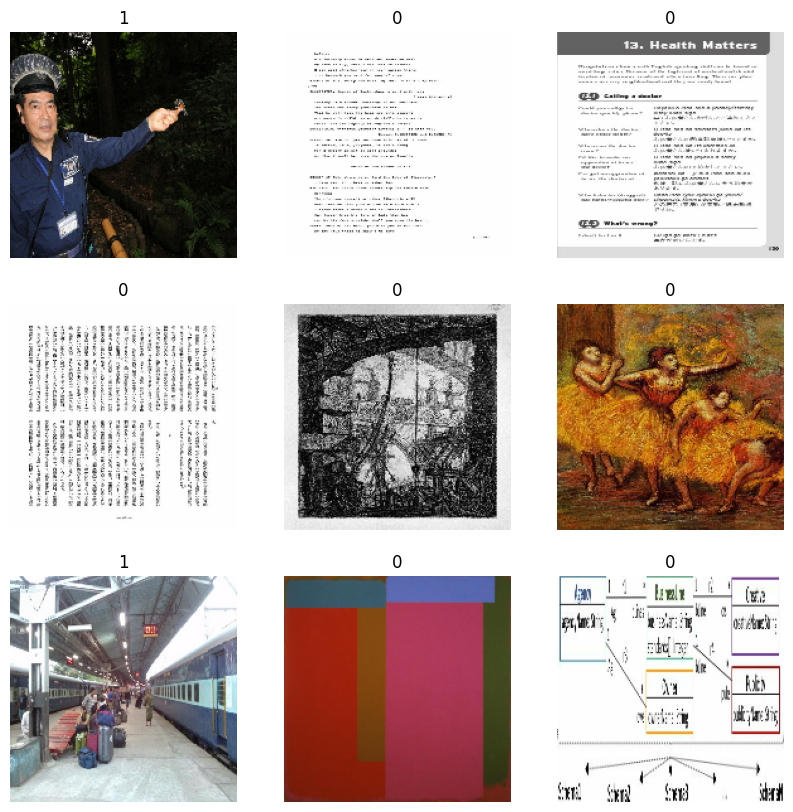

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.02),
])

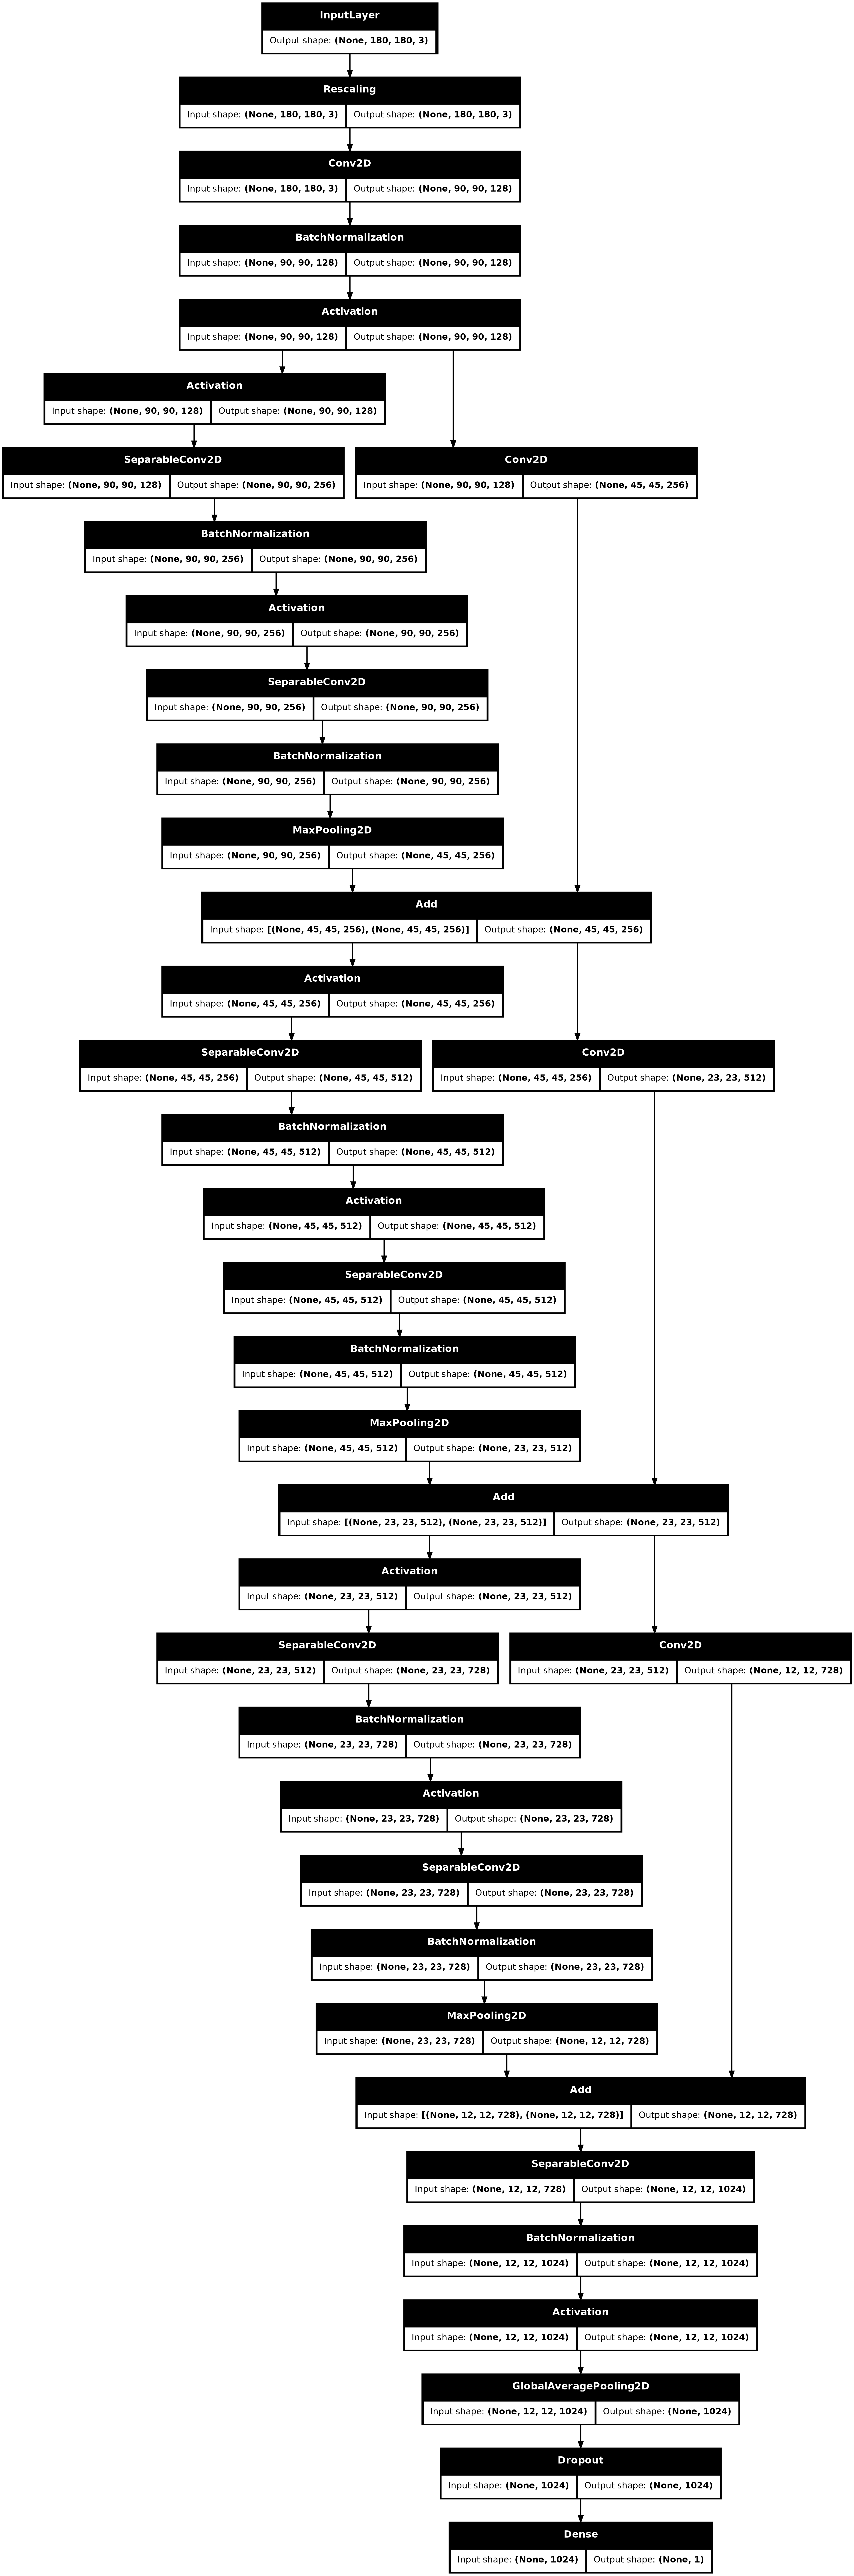

In [3]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [13]:
# TensorBoard logging
log_dir = "logs/fit"
tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    profile_batch=(10, 20),  # optional profiling window
)


2025-10-03 10:35:23.497649: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-10-03 10:35:23.497678: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-10-03 10:35:23.512353: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:136] Profiler session tear down.
I0000 00:00:1759480523.512461    1203 cupti_tracer.cc:1381] CUPTI activity buffer flushed


In [14]:
# Checkpoints
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    tensorboard_cb,
]

# Compile: BinaryCrossentropy from logits to match Dense(1, activation=None)
# model.compile(
#     optimizer=keras.optimizers.Adam(3e-4),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy(name="acc")],
# )

In [14]:
# TensorBoard logging
log_dir = "logs/fit"
tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    profile_batch=(10, 20),  # optional profiling window
)

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25


2025-10-03 11:51:22.443805: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-10-03 11:51:22.443834: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-10-03 11:51:22.476732: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:136] Profiler session tear down.
I0000 00:00:1759485082.609158     732 cupti_tracer.cc:1381] CUPTI activity buffer flushed


214/249 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - acc: 0.9953 - loss: 0.0133

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 108s 392ms/step - acc: 0.9954 - loss: 0.0128 - val_acc: 0.9294 - val_loss: 0.2787
Epoch 2/25
210/249 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - acc: 0.9968 - loss: 0.0093

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 354ms/step - acc: 0.9962 - loss: 0.0100 - val_acc: 0.9291 - val_loss: 0.3752
Epoch 3/25
203/249 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - acc: 0.9927 - loss: 0.0181

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - acc: 0.9951 - loss: 0.0132 - val_acc: 0.9481 - val_loss: 0.2878
Epoch 4/25
201/249 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - acc: 0.9913 - loss: 0.0227

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 355ms/step - acc: 0.9941 - loss: 0.0159 - val_acc: 0.9450 - val_loss: 0.2046
Epoch 5/25
196/249 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - acc: 0.9968 - loss: 0.0077

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - acc: 0.9967 - loss: 0.0091 - val_acc: 0.9252 - val_loss: 0.2967
Epoch 6/25
205/249 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step - acc: 0.9968 - loss: 0.0093

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 88s 353ms/step - acc: 0.9977 - loss: 0.0071 - val_acc: 0.9323 - val_loss: 0.4045
Epoch 7/25
206/249 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - acc: 0.9980 - loss: 0.0061

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - acc: 0.9974 - loss: 0.0080 - val_acc: 0.9385 - val_loss: 0.2993
Epoch 8/25
197/249 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - acc: 0.9889 - loss: 0.0290

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - acc: 0.9929 - loss: 0.0184 - val_acc: 0.9479 - val_loss: 0.2308
Epoch 9/25
193/249 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - acc: 0.9981 - loss: 0.0053

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - acc: 0.9974 - loss: 0.0062 - val_acc: 0.9392 - val_loss: 0.2121
Epoch 10/25
195/249 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - acc: 0.9984 - loss: 0.0048

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - acc: 0.9983 - loss: 0.0055 - val_acc: 0.9178 - val_loss: 0.3885
Epoch 11/25
202/249 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - acc: 0.9924 - loss: 0.0239

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - acc: 0.9949 - loss: 0.0147 - val_acc: 0.9538 - val_loss: 0.1858
Epoch 12/25
202/249 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - acc: 0.9978 - loss: 0.0066

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - acc: 0.9976 - loss: 0.0072 - val_acc: 0.9392 - val_loss: 0.2754
Epoch 13/25
199/249 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.9850 - loss: 0.0406

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - acc: 0.9913 - loss: 0.0231 - val_acc: 0.9423 - val_loss: 0.2330
Epoch 14/25
200/249 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - acc: 0.9964 - loss: 0.0114

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 332ms/step - acc: 0.9972 - loss: 0.0083 - val_acc: 0.9511 - val_loss: 0.2180
Epoch 15/25
199/249 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.9975 - loss: 0.0063

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - acc: 0.9979 - loss: 0.0058 - val_acc: 0.9268 - val_loss: 0.3544
Epoch 16/25
202/249 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - acc: 0.9987 - loss: 0.0040

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 343ms/step - acc: 0.9985 - loss: 0.0047 - val_acc: 0.9547 - val_loss: 0.1910
Epoch 17/25
201/249 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.9989 - loss: 0.0031

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 339ms/step - acc: 0.9977 - loss: 0.0059 - val_acc: 0.9063 - val_loss: 0.5119
Epoch 18/25
194/249 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - acc: 0.9964 - loss: 0.0077

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - acc: 0.9970 - loss: 0.0075 - val_acc: 0.9396 - val_loss: 0.3589
Epoch 19/25
202/249 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - acc: 0.9972 - loss: 0.0067

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - acc: 0.9976 - loss: 0.0064 - val_acc: 0.9139 - val_loss: 0.5273
Epoch 20/25
196/249 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - acc: 0.9964 - loss: 0.0117

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - acc: 0.9960 - loss: 0.0117 - val_acc: 0.9588 - val_loss: 0.1820
Epoch 21/25
200/249 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.9982 - loss: 0.0079

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - acc: 0.9982 - loss: 0.0059 - val_acc: 0.9451 - val_loss: 0.2534
Epoch 22/25
195/249 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - acc: 0.9984 - loss: 0.0043

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - acc: 0.9977 - loss: 0.0057 - val_acc: 0.9445 - val_loss: 0.2233
Epoch 23/25
201/249 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.9972 - loss: 0.0078

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - acc: 0.9969 - loss: 0.0085 - val_acc: 0.9433 - val_loss: 0.2806
Epoch 24/25
208/249 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - acc: 0.9890 - loss: 0.0303

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - acc: 0.9943 - loss: 0.0162 - val_acc: 0.9521 - val_loss: 0.2303
Epoch 25/25
202/249 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - acc: 0.9985 - loss: 0.0041

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 333ms/step - acc: 0.9977 - loss: 0.0061 - val_acc: 0.9564 - val_loss: 0.2087


In [22]:
%load_ext tensorboard
%tensorboard --logdir logs/fit --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4463), started 1:54:04 ago. (Use '!kill 4463' to kill it.)

In [41]:
model.save('photomodel.keras')

In [5]:
model.save('Photo-Binaire.h5')

In [27]:
# model = tf.keras.models.load_model('photomodel.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
This image is 0.01% other and 99.99% photo.


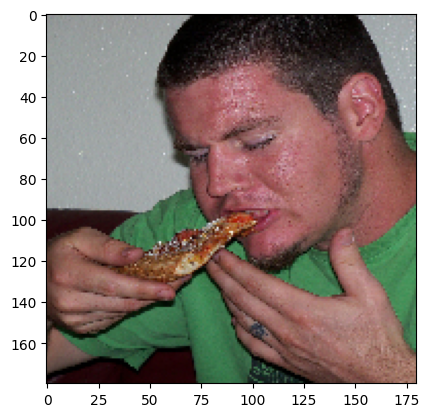

In [53]:
img = keras.utils.load_img("/mnt/c/Users/octav/Pictures/tensorflow test/photo_0069.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% other and {100 * score:.2f}% photo.")

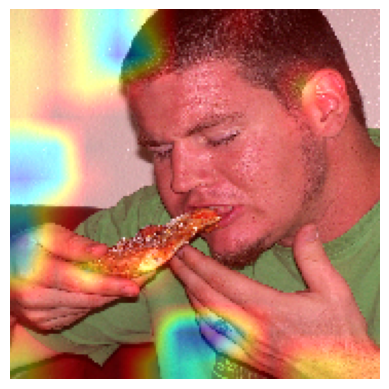

In [54]:
def display_gradcam_on_image(img, heatmap, alpha=0.4):
    import cv2
    import numpy as np
    # Convert PIL Image to NumPy array (if not already)
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    # Resize heatmap to match input image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()
display_gradcam_on_image(img, heatmap)


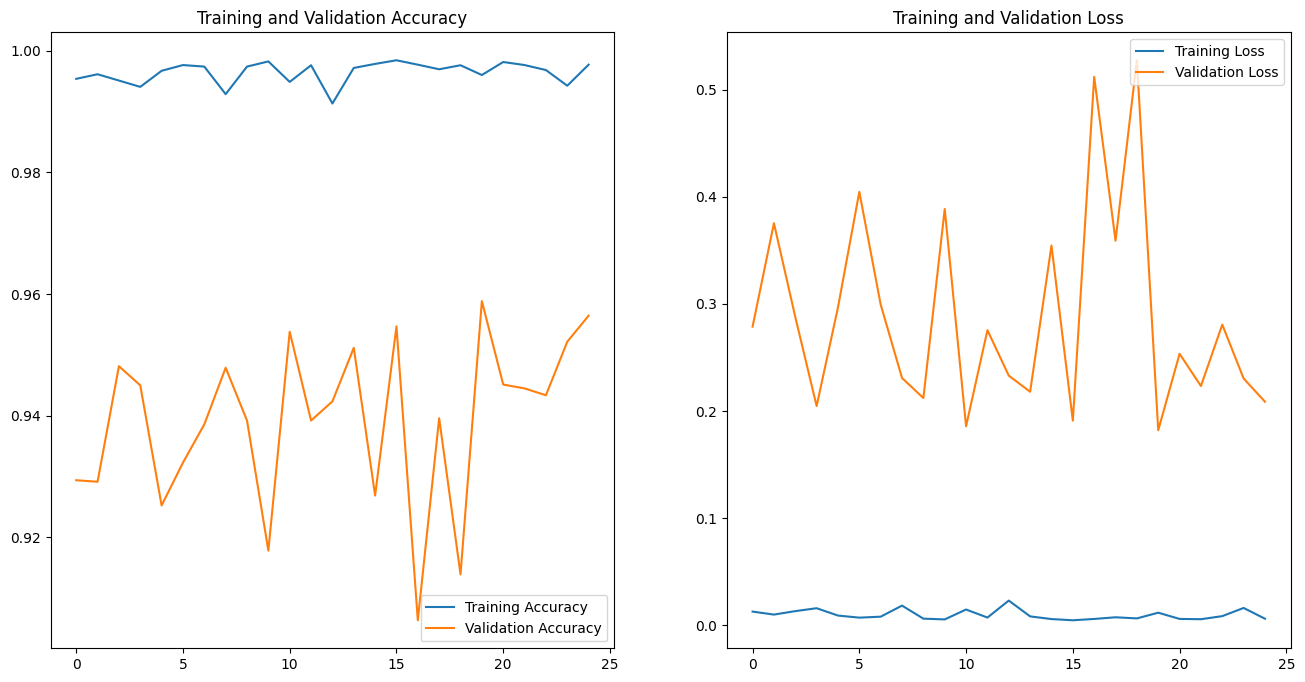

In [23]:
acc = history.history["acc"]         # Training binary accuracy
val_acc = history.history["val_acc"] # Validation binary accuracy
loss = history.history["loss"]           # Training loss
val_loss = history.history["val_loss"]   # Validation loss


epochs_range = range(epochs)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 45,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 45, 45,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 8,176,621 (31.19 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

 Optimizer params: 5,445,556 (20.77 MB)

In [36]:
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='separable_conv2d_6', pred_index=predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2025-10-03 14:08:04.669503: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-03 14:08:04.798888: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-03 14:08:05.464623: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-03 14:08:05.582840: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-03 14:08:05.913072: E external/local_xla/xla/stream_

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━

2025-10-03 14:08:26.121668: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


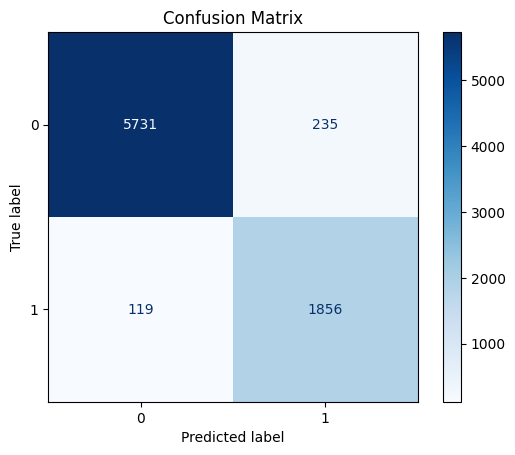

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Collect ground-truth and predictions from the dataset
y_true = []
y_pred = []

for batch in val_ds:  # or use test_set
    images, labels = batch
    preds = model.predict(images)
    # For binary classification
    if preds.shape[-1] == 1:
        preds = (tf.sigmoid(preds).numpy() > 0.5).astype(int).flatten()
    else:
        preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()